In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Set the working directory to the location of this script
print("Current working directory:", os.getcwd())

data_files = {
    "c17_0012": os.path.expanduser("~/work/vaping_project_data/original_all_core/original_core_2017_0012.tsv"),
    "c17_0810": os.path.expanduser("~/work/vaping_project_data/original_all_core/original_core_2017_0810.tsv"),
    "c18_0012": os.path.expanduser("~/work/vaping_project_data/original_all_core/original_core_2018_0012.tsv"),
    "c18_0810": os.path.expanduser("~/work/vaping_project_data/original_all_core/original_core_2018_0810.tsv"),
    "c19_0012": os.path.expanduser("~/work/vaping_project_data/original_all_core/original_core_2019_0012.tsv"),
    "c19_0810": os.path.expanduser("~/work/vaping_project_data/original_all_core/original_core_2019_0810.tsv"),
    "c20_0012": os.path.expanduser("~/work/vaping_project_data/original_all_core/original_core_2020_0012.tsv"),
    "c20_0810": os.path.expanduser("~/work/vaping_project_data/original_all_core/original_core_2020_0810.tsv"),
    "c21_0012": os.path.expanduser("~/work/vaping_project_data/original_all_core/original_core_2021_0012.tsv"),
    "c21_0810": os.path.expanduser("~/work/vaping_project_data/original_all_core/original_core_2021_0810.tsv"),
    "c22_0012": os.path.expanduser("~/work/vaping_project_data/original_all_core/original_core_2022_0012.tsv"),
    "c22_0810": os.path.expanduser("~/work/vaping_project_data/original_all_core/original_core_2022_0810.tsv"),
    "c23_0012": os.path.expanduser("~/work/vaping_project_data/original_all_core/original_core_2023_0012.tsv"),
    "c23_0810": os.path.expanduser("~/work/vaping_project_data/original_all_core/original_core_2023_0810.tsv")
}
dfs = {}
for key, filepath in data_files.items():
    try:
        dfs[key] = pd.read_csv(filepath, sep='\t', low_memory=False)
        print(f"Loaded {key} with shape {dfs[key].shape}")
    except Exception as e:
        print(f"Error loading {key} from {filepath}: {e}")

results = {}
for key, df in dfs.items():
    results[key] = df.head(10)
    print(f"\nSummary for {key}:")
    print(results[key])


In [ ]:
def transform_nicotine(df, old_var):
    """
    Create a new column 'nicotine12' from the given old variable
    and drop the original column.
    """
    df = df.copy()
    df['nicotine12'] = df[old_var]
    df.drop(columns=[old_var], inplace=True)
    return df

def calculate_frequency(df, tibble_name):
    """
    Calculate count and percentage for the 'nicotine12' column.
    Adds the tibble name as a column.
    """
    freq = df['nicotine12'].value_counts(dropna=False).reset_index()
    freq.columns = ['nicotine12', 'n']
    freq['Percentage'] = freq['n'] / freq['n'].sum() * 100
    freq.insert(0, 'tibble', tibble_name)
    return freq

def add_grade_column(df, tibble_name):
    """
    For datasets ending with "0810", add a 'grade' column by copying V501 and drop V501.
    """
    df = df.copy()
    if tibble_name.endswith("0810"):
        df['grade'] = df['V501']
        df.drop(columns=['V501'], inplace=True)
    return df

def add_grade_column_0012(df, tibble_name):
    """
    For datasets ending with "0012", add a 'grade' column with value 12.
    """
    df = df.copy()
    if tibble_name.endswith("0012"):
        df['grade'] = 12
    return df

def add_wave_column(df, tibble_name):
    """
    Extract the two-digit year from the tibble name and add a 'wave' column.
    (e.g. "c17_0012" becomes 2017)
    """
    df = df.copy()
    try:
        year = int(tibble_name[1:3]) + 2000
    except Exception:
        year = np.nan
    df['wave'] = year
    return df

def add_sex_column(df, col_name):
    """
    Recode the given column so that:
      - 1 becomes 0 (male)
      - 2 becomes 1 (female)
      - all other values become np.nan.
    Then drop the original column.
    """
    df = df.copy()
    df['sex'] = df[col_name].apply(lambda x: 0 if x == 1 else (1 if x == 2 else np.nan))
    df.drop(columns=[col_name], inplace=True)
    return df

def add_race_column(df, tibble_name):
    """
    Create a new 'race' column by copying V2151 (if tibble ends with "0012")
    or V1070 (if tibble ends with "0810") and drop the original.
    """
    df = df.copy()
    if tibble_name.endswith("0012"):
        df['race'] = df['V2151']
        df.drop(columns=['V2151'], inplace=True)
    elif tibble_name.endswith("0810"):
        df['race'] = df['V1070']
        df.drop(columns=['V1070'], inplace=True)
    return df

def add_nicotine12d(df):
    """
    Dichotomize 'nicotine12' so that:
      - Values -9 and -8 become np.nan,
      - 1 becomes 0 (non-smoker),
      - Values 2 or greater become 1 (smoker).
    """
    df = df.copy()
    conditions = [
        df['nicotine12'].isin([-9, -8]),
        df['nicotine12'] == 1,
        df['nicotine12'] >= 2
    ]
    choices = [np.nan, 0, 1]
    df['nicotine12d'] = np.select(conditions, choices, default=np.nan)
    return df

In [7]:
# =============================================================================
# 3. Preprocessing Workflow (Integration with Loaded Data)
# =============================================================================

# (a) Transform the nicotine variable for each dataset using the mapping below.
waves = {
    "c17_0012": "V2568", "c17_0810": "V7650",
    "c18_0012": "V2568", "c18_0810": "V7650",
    "c19_0012": "V2581", "c19_0810": "V7762",
    "c20_0012": "V2581", "c20_0810": "V7762",
    "c21_0012": "V7781", "c21_0810": "V7781",
    "c22_0012": "V7781", "c22_0810": "V7781",
    "c23_0012": "V7781", "c23_0810": "V7781"
}

for wave, old_var in waves.items():
    if wave in dfs:
        dfs[wave] = transform_nicotine(dfs[wave], old_var)
    else:
        print(f"Warning: {wave} not found.")

In [8]:
# (b) Calculate frequency summaries for nicotine12.
tibble_names = ["c17_0012", "c17_0810", "c18_0012", "c18_0810", "c19_0012",
                "c19_0810", "c20_0012", "c20_0810", "c21_0012", "c21_0810",
                "c22_0012", "c22_0810", "c23_0012", "c23_0810"]

frequency_list = []
for name in tibble_names:
    if name in dfs:
        freq_df = calculate_frequency(dfs[name], name)
        frequency_list.append(freq_df)
    else:
        print(f"Warning: {name} not found.")

frequency_df = pd.concat(frequency_list, ignore_index=True)
print("\nFrequency table for nicotine12:")
print(frequency_df)


Frequency table for nicotine12:
      tibble  nicotine12      n  Percentage
0   c17_0012          -9   9443   69.834344
1   c17_0012           1   3299   24.397279
2   c17_0012           2    276    2.041118
3   c17_0012           7    158    1.168466
4   c17_0012           3    130    0.961396
..       ...         ...    ...         ...
77  c23_0012           1   1888   24.894515
78  c23_0012          -9    344    4.535865
79  c23_0810           2  11935   81.003122
80  c23_0810           1   2118   14.374915
81  c23_0810          -9    681    4.621963

[82 rows x 4 columns]


In [9]:
# (c) Add grade columns.
for name in tibble_names:
    if name in dfs:
        dfs[name] = add_grade_column(dfs[name], name)
        dfs[name] = add_grade_column_0012(dfs[name], name)
    else:
        print(f"Warning: {name} not found.")

# (d) Add cohort year ('wave') column.
for name in tibble_names:
    if name in dfs:
        dfs[name] = add_wave_column(dfs[name], name)
    else:
        print(f"Warning: {name} not found.")

# (e) Recode Sex.
# For datasets with column V2150 (typically the "0012" waves).
v2150_names = [f"c{year}_0012" for year in range(17, 24)]
for name in v2150_names:
    if name in dfs:
        dfs[name] = add_sex_column(dfs[name], "V2150")
    else:
        print(f"Warning: {name} not found.")

# For datasets with column V7202 (the "0810" waves).
v7202_names = [f"c{year}_0810" for year in range(17, 24)]
for name in v7202_names:
    if name in dfs:
        dfs[name] = add_sex_column(dfs[name], "V7202")
    else:
        print(f"Warning: {name} not found.")

# (f) Add Race variable.
for name in tibble_names:
    if name in dfs:
        dfs[name] = add_race_column(dfs[name], name)
    else:
        print(f"Warning: {name} not found.")

# (g) Dichotomize nicotine12.
for name in tibble_names:
    if name in dfs:
        dfs[name] = add_nicotine12d(dfs[name])
        print(f"Processed dataset: {name}")
    else:
        print(f"Warning: {name} not found.")

Processed dataset: c17_0012
Processed dataset: c17_0810
Processed dataset: c18_0012
Processed dataset: c18_0810
Processed dataset: c19_0012
Processed dataset: c19_0810
Processed dataset: c20_0012
Processed dataset: c20_0810
Processed dataset: c21_0012
Processed dataset: c21_0810
Processed dataset: c22_0012
Processed dataset: c22_0810
Processed dataset: c23_0012
Processed dataset: c23_0810


In [10]:
# (h) Merge all 12th grade data.
twelve_grade_names = ["c17_0012", "c18_0012", "c19_0012", "c20_0012", "c21_0012", "c22_0012"]

# Identify common columns across these datasets.
common_columns = None
for name in twelve_grade_names:
    if name in dfs:
        cols = set(dfs[name].columns)
        common_columns = cols if common_columns is None else common_columns.intersection(cols)
    else:
        print(f"Warning: {name} not found.")

common_columns = list(common_columns) if common_columns is not None else []

# For each dataset, retain only the common columns.
datasets_common = [dfs[name][common_columns].copy() for name in twelve_grade_names if name in dfs]

# Merge (concatenate) the datasets.
merged_data = pd.concat(datasets_common, ignore_index=True)

# Define the path where the merged data will be saved
merged_path = "~/work/vaping_project_data/merged_data_g12.csv"

# Ensure the directory exists before saving the file
os.makedirs(os.path.dirname(merged_path), exist_ok=True)

# Save the merged data to CSV
merged_data.to_csv(merged_path, index=False)

print(f"\nMerged 12th grade data saved to '{merged_path}'.")


Merged 12th grade data saved to 'vaping_project_data/merged_data_g12.csv'.


In [19]:
# -----------------------------------------------------------------------------
# Merge All 8th and 10th Grade Data (DataFrames ending with "0810")
# -----------------------------------------------------------------------------

# Identify all dataset names ending with "0810"
eighth_tenth_grade_names = [name for name in dfs.keys() if name.endswith("0810")]

# Identify common columns across these datasets.
common_columns = None
for name in eighth_tenth_grade_names:
    if name in dfs:
        cols = set(dfs[name].columns)
        common_columns = cols if common_columns is None else common_columns.intersection(cols)
    else:
        print(f"Warning: {name} not found.")

common_columns = list(common_columns) if common_columns is not None else []

# For each dataset, retain only the common columns.
datasets_common = [dfs[name][common_columns].copy() for name in eighth_tenth_grade_names if name in dfs]

# Merge (concatenate) the datasets.
merged_data_0810 = pd.concat(datasets_common, ignore_index=True)

# Define the path where the merged data will be saved
merged_path_0810 = "~/work/vaping_project_data/merged_data_g0810.csv"

# Ensure the directory exists before saving the file
os.makedirs(os.path.dirname(merged_path_0810), exist_ok=True)

# Save the merged data to CSV
merged_data_0810.to_csv(merged_path_0810, index=False)

print(f"\nMerged 8th and 10th grade data saved to '{merged_path_0810}'.")


Merged 8th and 10th grade data saved to 'vaping_project_data/merged_data_g0810.csv'.


In [23]:
# -----------------------------------------------------------------------------
# Missing Data Analysis
# -----------------------------------------------------------------------------

total_missing = merged_data.isna().sum().sum()
print("\nTotal missing values:", total_missing)

# Count negative values in numeric columns.
numeric_cols = merged_data.select_dtypes(include=[np.number]).columns
negative_counts = merged_data[numeric_cols].apply(lambda x: (x < 0).sum())
negative_counts_df = pd.DataFrame({
    'Column': negative_counts.index,
    'Negative_Count': negative_counts.values
})
print("\nNegative value counts by numeric column:")
print(negative_counts_df)

# Replace negative codes (-9, -8) with NaN.
missing_codes = [-9, -8]
merged_data[numeric_cols] = merged_data[numeric_cols].replace({-9: np.nan, -8: np.nan})

# Compute missing counts and percentages.
missing_counts = merged_data.isna().sum()
missing_percent = (merged_data.isna().mean() * 100).round(2)
missing_summary = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percentage': missing_percent
}).sort_values(by='Missing_Percentage', ascending=False)
print("\nMissing values summary:")
print(missing_summary.to_string())


Total missing values: 2906810

Negative value counts by numeric column:
     Column  Negative_Count
0     V2174               0
1     V2912               0
2     V2157               0
3     V2200               0
4     V2493               0
..      ...             ...
160   V2206               0
161   V2918               0
162  V2106D               0
163   V2207               0
164  V2115D               0

[165 rows x 2 columns]

Missing values summary:
                Missing_Count  Missing_Percentage
V2205                   62281               97.12
V2206                   62247               97.07
V2207                   62245               97.06
V2200                   55773               86.97
V2199                   55736               86.91
V2198                   55727               86.90
V2204                   55630               86.75
V2203                   55601               86.70
V2202                   55586               86.68
V2305                   55125             

In [29]:
# =============================================================================
# 4. Further Data Preparation and Analysis for 12th Grade
# =============================================================================

# Reload the merged data
new_data = pd.read_csv(merged_path)
print("\nColumns in merged data:")
print(new_data.columns.tolist())

# Remove redundant columns.
cols_to_remove = [
    # Redundant dichotomized drug use predictors:
    "V2101D", "V2102D", "V2104D", "V2105D", "V2106D",
    "V2115D", "V2116D", "V2117D", "V2118D", "V2119D",
    "V2120D", "V2121D", "V2122D", "V2123D", "V2127D",
    "V2128D", "V2129D", "V2133D", "V2134D", "V2135D",
    "V2136D", "V2137D", "V2138D", "V2145D", "V2146D",
    "V2147D", "V2142D", "V2143D", "V2144D",
    # Useless info:
    "RESPONDENT_ID", "V1", "V3", "ARCHIVE_WT", "V16", "V17", "V2190",
    # Original label:
    "nicotine12",
    # 0 variance:
    "grade",
    # Remove auto-correlation:
    "V2102", "V2104", "V2020", "V7963", "V7966", "V2104", "V2106",
    "V2020", "V2022", "V7957", "V7959", "V2115", "V2117", "V2118",
    "V2120", "V2121", "V2123", "V2032", "V2034", "V2124", "V2126",
    "V2459", "V2461", "V2042", "V2044", "V2127", "V2129", "V2029",
    "V2031", "V2133", "V2135", "V2136", "V2138", "V2139", "V2141",
    "V2142", "V2144", "V2145", "V2147", "V2493", "V2495", "V7783",
    "V7785", "V7786", "V7788", "V7724",
    # Remove highly-correlated:
    "V2167", "V2170", "V2174", "V2192", "V2042", "V2103", "V2107",
    "V2043",
    # Remove vape nicotine related:
    "V2566", "V7780", "V7782", "V7789", "V7791", "V7793", "V7884",
    "V7887",
    # Remove high-missingness columns:
    "V2205", "V2206", "V2207", "V2200", "V2199", "V2198", 
    "V2204", "V2203", "V2202", "V2305", "V2918", "V2576", 
    "V2549", "V2564", "V2548", "V2547", "V2927", "V2009",
    "V2912", "V2003", "V2920", "V2307", "V2909", "V2919",
    "V2021", "V2030", "V2494", "V2908", "V2907", "V2146",
    "V2033", "V2169", "V2122", "V2119"
]
new_data.drop(columns=cols_to_remove, errors='ignore', inplace=True)
print("\nColumns after removal:")
print(new_data.columns.tolist())

# -----------------------------------------------------------------------------
# Missing Data Analysis
# -----------------------------------------------------------------------------

total_missing = new_data.isna().sum().sum()
print("\nTotal missing values:", total_missing)

# Count negative values in numeric columns.
numeric_cols = new_data.select_dtypes(include=[np.number]).columns
negative_counts = new_data[numeric_cols].apply(lambda x: (x < 0).sum())
negative_counts_df = pd.DataFrame({
    'Column': negative_counts.index,
    'Negative_Count': negative_counts.values
})
print("\nNegative value counts by numeric column:")
print(negative_counts_df)

# Replace negative codes (-9, -8) with NaN.
missing_codes = [-9, -8]
new_data[numeric_cols] = new_data[numeric_cols].replace({-9: np.nan, -8: np.nan})

# Drop individuals with missing values in nicotine12d, sex, or race
new_data.dropna(subset=["nicotine12d", "sex", "race"], how="any", inplace=True)

# **Check and print sample size after preprocessing**
sample_size = len(new_data)
print(f"\nSample size after preprocessing: {sample_size}")

# Compute missing counts and percentages after cleaning.
missing_counts = new_data.isna().sum()
missing_percent = (new_data.isna().mean() * 100).round(2)
missing_summary = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percentage': missing_percent
}).sort_values(by='Missing_Percentage', ascending=False)
print("\nMissing values summary after dropping rows missing 'nicotine12d', 'gender', or 'race':")
print(missing_summary)



Columns in merged data:
['V2174', 'V2912', 'V2157', 'V2200', 'V2493', 'nicotine12d', 'V49', 'V2495', 'V2134', 'V2153', 'V2122', 'V2116', 'V13', 'V2134D', 'V2140', 'V2104D', 'V2117D', 'V2101', 'grade', 'V2305', 'V2191', 'V2907', 'V2908', 'V2107', 'V2120', 'V2152', 'V2167', 'V2576', 'V2196', 'V2118D', 'V2033', 'V2043', 'V2121D', 'V2143D', 'V2181', 'V2105', 'V2549', 'V2021', 'V2030', 'V2138', 'V2138D', 'V2171', 'V2135D', 'V2176', 'V2202', 'V2201', 'V2127', 'V2186', 'V2144', 'V2173', 'V2029', 'V2189', 'V16', 'V2204', 'V2115', 'V2117', 'ARCHIVE_WT', 'V2146D', 'V2133D', 'V2145D', 'V2188', 'V2128', 'V2139', 'V2121', 'V2548', 'V2183', 'V2566', 'V2104', 'V2119D', 'V2135', 'V2166', 'V2205', 'RESPONDENT_ID', 'V2459', 'V2307', 'V2102D', 'V2116D', 'V2122D', 'V2909', 'V2142', 'V2182', 'V2169', 'V2919', 'V2137D', 'V2136', 'V2197', 'nicotine12', 'V2020', 'V2170', 'V2101D', 'V2198', 'V2128D', 'RESPONDENT_AGE', 'V2155', 'V2460', 'V2145', 'V2564', 'V2920', 'V2146', 'V2187', 'V2547', 'V2123D', 'V2137', '


Data structure:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27330 entries, 0 to 64127
Data columns (total 51 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   V2157           27089 non-null  float64
 1   nicotine12d     27330 non-null  float64
 2   V49             27138 non-null  float64
 3   V2134           27074 non-null  float64
 4   V2153           27077 non-null  float64
 5   V2116           26736 non-null  float64
 6   V13             27330 non-null  float64
 7   V2140           27158 non-null  float64
 8   V2101           27060 non-null  float64
 9   V2191           26236 non-null  float64
 10  V2152           27261 non-null  float64
 11  V2196           26045 non-null  float64
 12  V2181           25325 non-null  float64
 13  V2105           26467 non-null  float64
 14  V2171           26760 non-null  float64
 15  V2176           25571 non-null  float64
 16  V2201           25764 non-null  float64
 17  V2186         

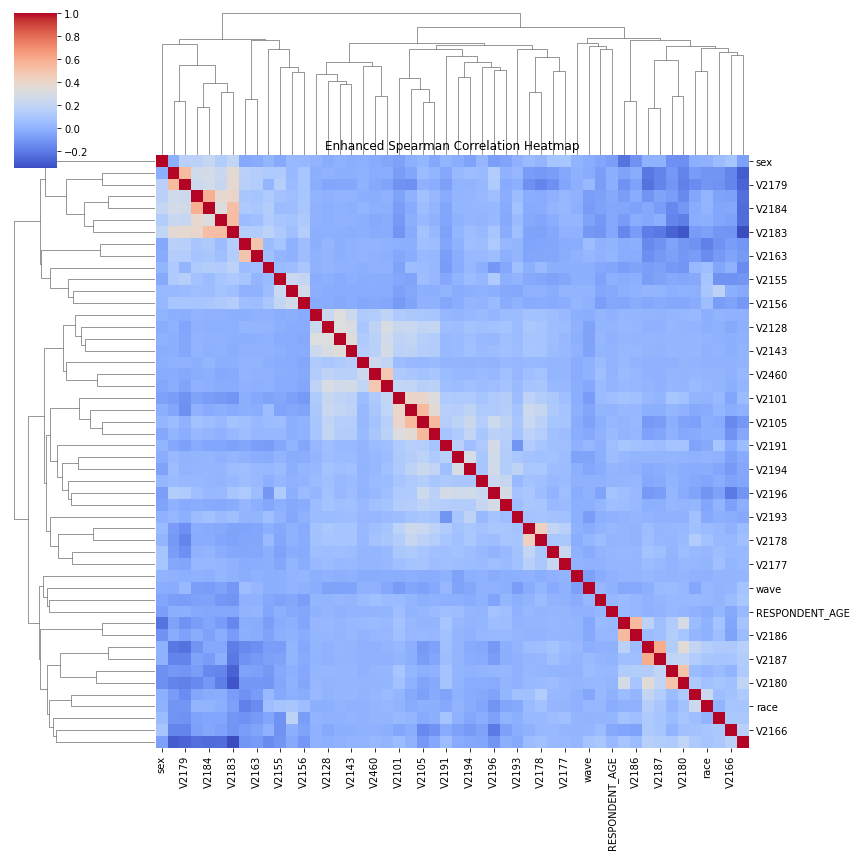


Highly correlated variable pairs (|corr| > 0.5):
  Variable1 Variable2  Correlation
0     V2116     V2105     0.537014
1     V2181     V2186     0.538938
2     V2105     V2108     0.544549
3     V2173     V2179     0.539722
4     V2189     V2184     0.580946
5     V2188     V2183     0.527055
6     V2183     V2184     0.523170
7     V2182     V2187     0.597073
8     V2185     V2180     0.500559


In [26]:
# -----------------------------------------------------------------------------
# Correlation Analysis for 12th grade
# -----------------------------------------------------------------------------
print("\nData structure:")
print(new_data.info())

# Select numeric variables (excluding the target variable 'nicotine12d' if desired).
cor_vars = new_data.drop(columns=['nicotine12d'], errors='ignore').select_dtypes(include=[np.number])

# Compute the Spearman correlation matrix.
cor_matrix_spearman = cor_vars.corr(method='spearman')

# Check for non-finite values in the correlation matrix.
if not np.all(np.isfinite(cor_matrix_spearman)):
    print("\nWarning: Non-finite values detected in the correlation matrix.")
    # Replace NaN or infinite values with 0 (or another appropriate value).
    cor_matrix_spearman = cor_matrix_spearman.fillna(0)
    cor_matrix_spearman = cor_matrix_spearman.replace([np.inf, -np.inf], 0)

print("\nSpearman Correlation Matrix:")
print(cor_matrix_spearman)

# Create an enhanced heatmap with clustering.
clustergrid = sns.clustermap(cor_matrix_spearman, cmap="coolwarm", figsize=(12, 12))
clustergrid.ax_heatmap.set_title("Enhanced Spearman Correlation Heatmap")
plt.show()

# Identify highly correlated pairs (absolute correlation > 0.5 and less than 1).
high_corr_pairs = []
cols = cor_matrix_spearman.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        corr_value = cor_matrix_spearman.iloc[i, j]
        if 0.5 < abs(corr_value) < 1:
            high_corr_pairs.append({
                "Variable1": cols[i],
                "Variable2": cols[j],
                "Correlation": corr_value
            })

high_corr_df = pd.DataFrame(high_corr_pairs)
print("\nHighly correlated variable pairs (|corr| > 0.5):")
print(high_corr_df)

In [31]:
# -----------------------------------------------------------------------------
# Save the Preprocessed Data for 12th grade
# -----------------------------------------------------------------------------
# Define the path where the processed data will be saved
processed_path = "~/work/vaping_project_data/processed_data_g12n.csv"

# Ensure the directory exists before saving the file
os.makedirs(os.path.dirname(processed_path), exist_ok=True)

# Save the preprocessed data to CSV
new_data.to_csv(processed_path, index=False)

print(f"\nProcessed data saved to '{processed_path}'.")


Processed data saved to '~/work/vaping_project_data/processed_data_g12n.csv'.


In [23]:
# =============================================================================
# 4. Further Data Preparation and Analysis for 8th and 10th Grade
# =============================================================================

# Reload the merged data
# Define the path to the merged data file
merged_path_0810 = "~/work/vaping_project_data/merged_data_g0810.csv"

# Check if the file exists before attempting to load it
if os.path.exists(merged_path_0810):
    # Reload the merged data from the CSV file with low_memory=False
    reloaded_data_0810 = pd.read_csv(merged_path_0810, low_memory=False)
    
    # Print the shape and a preview of the reloaded data
    print(f"\nReloaded 8th and 10th grade data with shape: {reloaded_data_0810.shape}")
    print("\nPreview of the reloaded data:")
    print(reloaded_data_0810.head())
    
    # List all column names
    print("\nAll column names in the dataset:")
    print(list(reloaded_data_0810.columns))
else:
    print(f"Error: File '{merged_path_0810}' does not exist. Please ensure the file has been saved.")


Reloaded 8th and 10th grade data with shape: (156841, 496)

Preview of the reloaded data:
   V7642  V7110  V7359  V7216  V8504  V8558        V5  V7327  V7374  V8556  \
0      1      1      4      5      5     -8  2.427542      2      3     -8   
1     -8      5      4      6     -8     -8  0.594924      3     -8     -8   
2      1      1      4      6     -8     -8  0.110906      7      3     -8   
3     -8      1      4      7      5      2  0.722531      3      9      2   
4     -8     -9     -9      3      3      3  0.549932      2      9      3   

   ...  V7353  V7098D  V7457  V7557  V7465  V7703  V7471  V7377  V7420  V7671  
0  ...     -8       0     -8     -8     -8      5     -8      4      4      1  
1  ...      1       0      1      0     -9     -8     -9     -8      2     -8  
2  ...     -8       0     -8     -8     -8      2     -8      3      3     -8  
3  ...      1      -8     -8     -8     -8     -8     -8     -8      3     -8  
4  ...      2      -8     -8     -8     